In [1]:
import pandas as pd
import os
import numpy as np
from hydra import initialize, compose
from omegaconf import OmegaConf

from deep_model import UTSDataset
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader
import torch

from utils import normalize_data, separate_data
from quantum_model import QuantumCircuit
from deep_model import MeanSquareError, Net, train_model_deep

In [2]:
HOME_PATH = "../"
with initialize(config_path="../configs/"):
    data_cfg = compose(config_name="data_path")
data_cfg = OmegaConf.create(data_cfg)

/tmp/ipykernel_26229/4189321069.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):


In [3]:
filter_uts_training_path = os.path.join(HOME_PATH, data_cfg.UTS_data.processed_data.filter_train)
filter_uts_testing_path = os.path.join(HOME_PATH, data_cfg.UTS_data.processed_data.filter_test)

save_model_path = os.path.join(HOME_PATH, data_cfg.model_train.best_model_state)
loss_train_path = os.path.join(HOME_PATH, data_cfg.model_train.loss_train)
loss_val_path = os.path.join(HOME_PATH, data_cfg.model_train.loss_val)

save_data_path_kernel_pca_cosine_64 = os.path.join(HOME_PATH, data_cfg.UTS_data.kernel_pca_cosine_64)

In [4]:
data_train = pd.read_csv(filter_uts_training_path).drop(columns=["Time"])
data_test = pd.read_csv(filter_uts_testing_path).drop(columns=["Time"])

In [5]:
# uncomment when run againt

# # normalize data from dataframe
# uts_filter_train_data = normalize_data(data_train)
# uts_filter_test_data = normalize_data(data_test)

# # separate data from dataframe
# X_train, y_train = separate_data(uts_filter_train_data)
# X_test, y_test = separate_data(uts_filter_test_data)

# # standard data
# scl = StandardScaler()
# X_train_scaled = scl.fit_transform(X_train)
# X_test_scaled = scl.transform(X_test)

# # transformer PCA
# transformer = KernelPCA(n_components=64, kernel="cosine", random_state=100)
# # transformer = PCA(n_components=0.91, random_state=100)
# X_train_transformed = transformer.fit_transform(X_train_scaled)
# X_test_transformed = transformer.transform(X_test_scaled)

# X_train_transformed.shape, X_test_transformed.shape

In [6]:
# np.savez(
#     save_data_path_kernel_pca_cosine_64, 
#     np.array(X_train_transformed), 
#     np.array(y_train), 
#     np.array(X_test_transformed), 
#     np.array(y_test)
# )

In [7]:
data = np.load(save_data_path_kernel_pca_cosine_64)
X_train = data['arr_0']
y_train = data['arr_1']
X_test = data['arr_2']
y_test = data['arr_3']

datasets = {
    "train": UTSDataset(X_train, y_train),
    "val": UTSDataset(X_test, y_test)
}

## demo 1: batch_size: 32 | 16
## demo 2: batch_size: 16 | 4
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=32, shuffle=True, num_workers=os.cpu_count()),
    "val": DataLoader(datasets["val"], batch_size=4, shuffle=True, num_workers=os.cpu_count())
}

dataset_sizes = {
    "train": len(datasets["train"]), 
    "val": len(datasets["val"])
}

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9108, 64), (9108, 2), (388, 64), (388, 2))

In [9]:
# Display image and label.
train_features, train_labels = next(iter(dataloaders["train"]))
test_features, test_labels = next(iter(dataloaders["val"]))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 64])
Labels batch shape: torch.Size([32, 2])


Expected value for rotation pi [0.         0.80859375 0.         0.671875   0.         0.65234375
 0.         0.5859375  0.         0.80664062 0.73046875 0.
 0.         0.67773438 0.         0.89648438 0.         0.8828125 ]


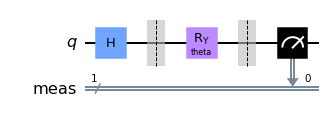

In [10]:
import qiskit
import torch
simulator = qiskit.Aer.get_backend('aer_simulator')
simulator.set_options(device='GPU')

circuit = QuantumCircuit(1, simulator, 512, is_add_noise=True)
print('Expected value for rotation pi {}'.format(circuit.forward(torch.rand(9))))
circuit.circuit.draw('mpl')
# circuit.plot(torch.rand(9))

In [11]:
model = Net(quantum=True)
# model.load_state_dict(torch.load(save_model_path))

# optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=0.001)

decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

loss_func = MeanSquareError()

In [12]:
import warnings
warnings.filterwarnings('ignore')

data_path = {
    "save_model_path": save_model_path, 
    "loss_train": loss_train_path, 
    "loss_val": loss_val_path,
}

train_model_deep(model, loss_func, optimizer, my_lr_scheduler, dataloaders, dataset_sizes, data_path, num_epochs=50)

Epoch 0 -> phase train: 
	Batch: 1/train: 


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)